<a href="https://colab.research.google.com/github/ibe16/ducktectron2/blob/master/DuckDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

# Install Detectron2 and dependencies

All this steps are in the [Detectron2 Beginner's Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

# Import libraries

In [0]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Google Drive

Use Google Drive as a common filesystem. You have to give permission to your Colab instance.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/SIGE/DuckDetection/"

Mounted at /content/gdrive


# Make the dataset

We'll use the Open Image dataset from Google to get images of ducks. We need metadata images on COCO json format, so I will explain next a simply pipeline to get them ready.

## 1. Download the data

[This tutorial](https://towardsdatascience.com/how-to-easily-download-googles-open-images-dataset-for-your-ai-apps-db552a82fc6) explains how to download and use CLI API to get images from a category and in **Pascal** format. After installing the CLI the command to use is:



```bash
$ oi_download_dataset --csv_dir ~/<dir_A> --base_dir ~/<dir_A> --labels Duck --format pascal --limit 50
```

So we get fifty images with ducks in them.



# 2. Transform metadata 

At this point we have fifty ducks images in Pascal format, but we need COCO format to be able to use Detectron2 models. To make it easy we can use Roboflow.

Roboflow is a platform to store datasets and it enables conversion from nearly any format (PASCAL VOC XML, CreateML JSON, COCO JSON, and more). Here is the [tutorial](https://blog.roboflow.ai/how-to-convert-annotations-from-voc-xml-to-coco-json/) I followed to set up the dataset. 

Roboflow also offers the possibility to apply some preprocessing and augmentation steps on the images. "Auto-orient" and "resize" are on by default, so I leave them, but you can delete them if they are not needed.

So once we have our images on Roboflow, we only have to download it with COCO json format for the metadata/annotations. Then, we upload it to Drive and continue with the notebook. 


# Data preprocessing

First of all, we have to change the annotations and put them in the correct format. They are already in the COCO format and that will make it easier for us to get them ready, but Detectron2 model needs some extra data our dataset doesn't have. Let's take a look at the changes we need to make.

These are the annotations data right now.

In [0]:
import pandas as pd
import json

annotations_dir = root_dir + f"train/annotations/_annotations.coco.json"
with open(annotations_dir) as json_file:
    annotations_json = json.load(json_file)

for i in range(5):
    print(annotations_json["annotations"][i], "\n")

{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [100, 194, 30.5, 39.5], 'area': 1204.75, 'segmentation': [], 'iscrowd': 0} 

{'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [106, 238, 41, 33], 'area': 1353, 'segmentation': [], 'iscrowd': 0} 

{'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [150, 12, 34.5, 26.5], 'area': 914.25, 'segmentation': [], 'iscrowd': 0} 

{'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [153, 136, 22, 32.5], 'area': 715, 'segmentation': [], 'iscrowd': 0} 

{'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [223, 143, 53, 49], 'area': 2597, 'segmentation': [], 'iscrowd': 0} 



To train models we need the bounding box that contains the object and a poly (segmentation) that describes the silhouette. Open Image dataset is used for object detection, so it doesn't have segmentation information. 

We have the bounding box in the format (x_top_left, y_top_left, width, height). That's correct and it's important that we know it because we will use it to create the polygon.

We only need to construct the segmentation polygon. Since the dataset is not for segmentation let just use a square.




So now let's create the segmentation polygon.

In [0]:
import itertools

for item in annotations_json["annotations"]:
    xmin = item["bbox"][0] # x_top_left
    ymin = item["bbox"][1] # y_top_left
    xmax = xmin + item["bbox"][2]  # width
    ymax = ymin + item["bbox"][3]  # height

    poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]

    poly = list(itertools.chain.from_iterable(poly))

    item["segmentation"]=[poly]



In [0]:
for i in range(5):
    print(annotations_json["annotations"][i], "\n")

{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [100, 194, 30.5, 39.5], 'area': 1204.75, 'segmentation': [[100, 194, 130.5, 194, 130.5, 233.5, 100, 233.5]], 'iscrowd': 0} 

{'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [106, 238, 41, 33], 'area': 1353, 'segmentation': [[106, 238, 147, 238, 147, 271, 106, 271]], 'iscrowd': 0} 

{'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [150, 12, 34.5, 26.5], 'area': 914.25, 'segmentation': [[150, 12, 184.5, 12, 184.5, 38.5, 150, 38.5]], 'iscrowd': 0} 

{'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [153, 136, 22, 32.5], 'area': 715, 'segmentation': [[153, 136, 175, 136, 175, 168.5, 153, 168.5]], 'iscrowd': 0} 

{'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [223, 143, 53, 49], 'area': 2597, 'segmentation': [[223, 143, 276, 143, 276, 192, 223, 192]], 'iscrowd': 0} 



That's all. Now we have the polygon. We save it in Drive.

In [0]:
annotations_dir = root_dir + f"train/annotations/duck_annotations.json"
with open(annotations_dir, 'w') as outfile:
    json.dump(annotations_json, outfile)

# Register the dataset

In order to train an existing Detectron2 model on a costum dataset we'll have to registrer it first.

There is a tutorial at the [official Github](https://github.com/facebookresearch/detectron2).



In [0]:
from detectron2.data.datasets import register_coco_instances
images_dir = root_dir + f"train/images"
register_coco_instances("ducks_dataset", {}, annotations_dir, images_dir)

In [0]:
ducks_metadata = MetadataCatalog.get("ducks_dataset")
dataset_dicts = DatasetCatalog.get("ducks_dataset")

WARNING [06/01 04:56:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/01 04:56:56 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/gdrive/My Drive/SIGE/DuckDetection/train/annotations/duck_annotations.json


In [0]:
print(json.dumps(dataset_dicts, indent=4))

[
    {
        "file_name": "/content/gdrive/My Drive/SIGE/DuckDetection/train/images/004cb816b28cb15c_jpg.rf.21bbfa06106d9d6e19bf13ef3fac5f4e.jpg",
        "height": 416,
        "width": 416,
        "image_id": 0,
        "annotations": [
            {
                "iscrowd": 0,
                "bbox": [
                    100,
                    194,
                    30.5,
                    39.5
                ],
                "category_id": 1,
                "segmentation": [
                    [
                        100,
                        194,
                        130.5,
                        194,
                        130.5,
                        233.5,
                        100,
                        233.5
                    ]
                ],
                "bbox_mode": 1
            },
            {
                "iscrowd": 0,
                "bbox": [
                    106,
                    238,
                    41,
       

Let's verify that all is correct and we can load data. We'll use Detectron2 `Visualizer` to see the image annotations.





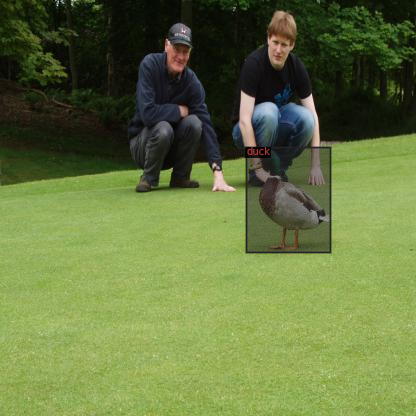

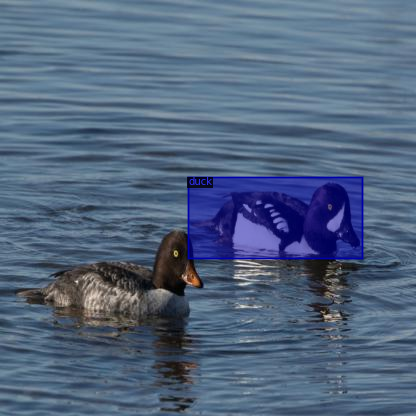

In [0]:
import random

for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ducks_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

And that's all. We've just obtained a custom dataset about ducks and we are ready to continue with the next step, training the model.

# Training

Now, let's train a coco-pretrained R50-FPN model on the ducks dataset. LEGGOO!!!

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ducks_dataset",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Only one class Duck

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/01 04:57:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:41, 10.4MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (3,) in the model!


[06/01 04:57:52 d2.engine.train_loop]: Starting training from iteration 0
[06/01 04:58:20 d2.utils.events]:  eta: 0:06:19  iter: 19  total_loss: 2.651  loss_cls: 1.044  loss_box_reg: 0.778  loss_mask: 0.647  loss_rpn_cls: 0.008  loss_rpn_loc: 0.007  time: 1.3591  data_time: 0.0735  lr: 0.000400  max_mem: 4386M
[06/01 04:58:47 d2.utils.events]:  eta: 0:05:58  iter: 39  total_loss: 1.412  loss_cls: 0.282  loss_box_reg: 0.620  loss_mask: 0.430  loss_rpn_cls: 0.005  loss_rpn_loc: 0.008  time: 1.3531  data_time: 0.0051  lr: 0.000799  max_mem: 4386M
[06/01 04:59:13 d2.utils.events]:  eta: 0:05:25  iter: 59  total_loss: 0.907  loss_cls: 0.128  loss_box_reg: 0.428  loss_mask: 0.307  loss_rpn_cls: 0.010  loss_rpn_loc: 0.005  time: 1.3371  data_time: 0.0046  lr: 0.001199  max_mem: 4386M
[06/01 04:59:40 d2.utils.events]:  eta: 0:04:58  iter: 79  total_loss: 0.719  loss_cls: 0.139  loss_box_reg: 0.351  loss_mask: 0.242  loss_rpn_cls: 0.008  loss_rpn_loc: 0.010  time: 1.3426  data_time: 0.0048  lr:

Save the model.

In [0]:
torch.save(trainer.model.state_dict(), root_dir+"model_duck.pth")

# Predictions

Now we can perfom inference. First, we need to create a predictor using the model we've just trained.

For the sake of simplicity we are using the same dataset to validate the model. If you want to have a validation and a test dataset, you only have to create and register them in the same way.

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(root_dir, "model_duck.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ducks_dataset", )
predictor = DefaultPredictor(cfg)

Then let's make predictions.

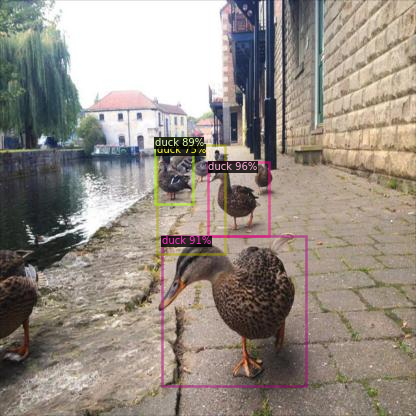

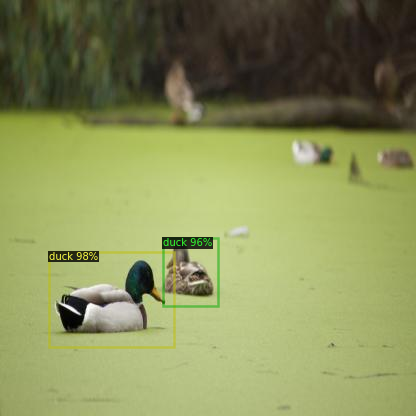

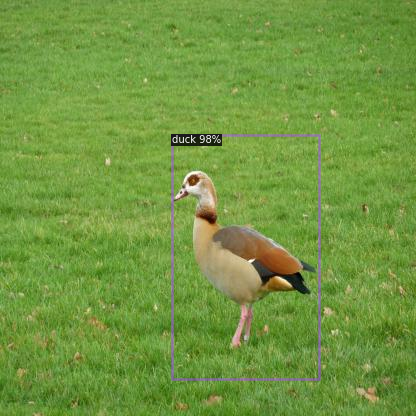

In [0]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ducks_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    
    instances = outputs["instances"].to("cpu")
    instances.remove('pred_masks')
    v = v.draw_instance_predictions(instances)
    result = v.get_image()[:, :, ::-1]
    cv2_imshow(result)


And that's all folks. This shows how simple it's to use Detectron2 in order to use your own images. Now feel free to try using another model or another dataset and incorporate it into your project or just try this wonderful tool. See ya :D 

# References

[Face Detection on Custom Dataset with Detectron2 and PyTorch using Python](https://towardsdatascience.com/face-detection-on-custom-dataset-with-detectron2-and-pytorch-using-python-23c17e99e162) 

[How to train Detectron2 with Custom COCO Datasets](https://colab.research.google.com/github/Tony607/detectron2_instance_segmentation_demo/blob/master/Detectron2_custom_coco_data_segmentation.ipynb#scrollTo=U5LhISJqWXgM )

[Detectron2 documentation use a custom dataset](https://detectron2.readthedocs.io/tutorials/datasets.html?highlight=fast%20cnn#standard-dataset-dicts )

[How to Easily Download Google's Open Images Dataset for your AI Apps](https://towardsdatascience.com/how-to-easily-download-googles-open-images-dataset-for-your-ai-apps-db552a82fc6)

[COCO and Pascal VOC data formar for Object detection](https://towardsdatascience.com/how-to-easily-download-googles-open-images-dataset-for-your-ai-apps-db552a82fc6)

[How to Convert Annotations from PASCAL VOC XML to COCO JSON](https://blog.roboflow.ai/how-to-convert-annotations-from-voc-xml-to-coco-json/)